<a href="https://colab.research.google.com/github/Jinops/cnn-rps-game/blob/reference-model/cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import math

**Generate Datasets**

In [13]:
# mount google drive
# original image dataset: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

from google.colab import drive

drive.mount('/content/gdrive')
dir = "/content/gdrive/MyDrive/Colab Notebooks/rps/"
categories = ["rock", "paper", "scissors"]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
width = 182 # original : 300
height = 128 # original: 200
input_shape = (height, width, 3)

def get_image_to_array(image_path):
  image = Image.open(image_path)
  image = image.resize((width, height))

  im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
  im_arr = im_arr.reshape(input_shape)

  return im_arr

def get_data():
  x_images = []
  y_categories = []
  for index, category in enumerate(list(categories)):
    for file_name in os.listdir(dir + 'images/' +category):
      image_path = dir + 'images/' + category + '/' + file_name
      x_images.append(get_image_to_array(image_path))
      y_categories.append(index)

  return np.array(x_images), np.array(y_categories)

Image count: 2188
Image matrix: 3*182*128


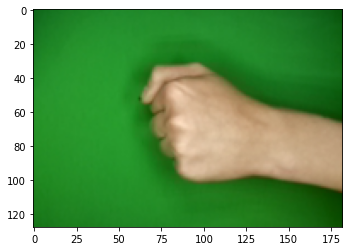

In [4]:
images, categories = get_data()

print("Image count:", len(images))
print("Image matrix: %d*%d*%d" %(len(images[0][0][0]),len(images[0][0]),len(images[0])))
plt.imshow(images[0])

In [5]:
train_ratio = 0.7
split_index = math.floor(len(images) * 0.7)

x_train, x_test = images[:split_index], images[split_index:]
y_train, y_test = categories[:split_index], categories[split_index:]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # convert RGB -> 0..1
x_test /= 255 # convert RGB -> 0..1

y_train = utils.to_categorical(y_train, len(categories))
y_test = utils.to_categorical(y_test, len(categories))

print('count')
print(' x_train: %d | x_test: %d' %(x_train.shape[0], x_test.shape[0]))
print(' y_train: %d | y_test: %d' %(y_train.shape[0], y_test.shape[0]))

count
 x_train: 1531 | x_test: 657
 y_train: 1531 | y_test: 657


**Model design**

In [6]:
learning_rate = 0.01

batch_size = 32
epochs = 50
validation_split = 0.2

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [7]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape, name='conv1'))
model.add(layers.MaxPooling2D((2,2),strides=(1,1), padding='same', name='pool1'))
model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation = 'relu', input_shape=input_shape, name='conv2'))
model.add(layers.MaxPooling2D((2,2),strides=(1,1), padding='same', name='pool2'))

model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=len(categories), activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=learning_rate), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 182, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 128, 182, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 128, 182, 32)      9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 128, 182, 32)      0         
                                                                 
 flatten (Flatten)           (None, 745472)            0         
                                                                 
 dense (Dense)               (None, 512)               381682176 
                                                                 
 dense_1 (Dense)             (None, 2188)              1

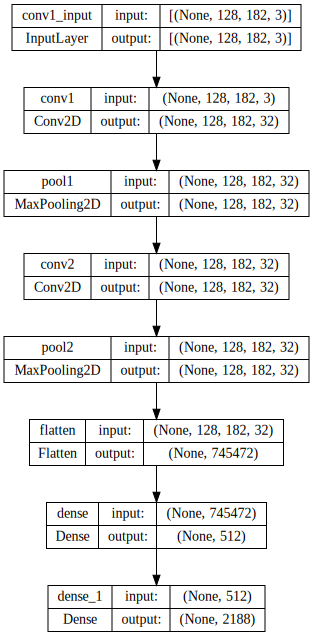

In [8]:
# draw model 

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

In [9]:
hist = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1
)

score = model.evaluate(x_test, y_test, verbose=1)
print(' - test_loss:', score[0], ' - test_acc:', score[1])

model.save(dir + "model.h5")

Epoch 1/50
39/39 [==============================] - 292s 7s/step - loss: 1.9407 - accuracy: 0.6315 - val_loss: 4.0912 - val_accuracy: 0.6124
Epoch 2/50
39/39 [==============================] - 284s 7s/step - loss: 0.5575 - accuracy: 0.7647 - val_loss: 4.3874 - val_accuracy: 0.6254
Epoch 3/50
39/39 [==============================] - 266s 7s/step - loss: 0.4783 - accuracy: 0.7982 - val_loss: 4.5296 - val_accuracy: 0.6678
Epoch 4/50
39/39 [==============================] - 269s 7s/step - loss: 0.3987 - accuracy: 0.8448 - val_loss: 4.6675 - val_accuracy: 0.6840
Epoch 5/50
39/39 [==============================] - 276s 7s/step - loss: 0.3764 - accuracy: 0.8472 - val_loss: 4.9476 - val_accuracy: 0.5309
Epoch 6/50
21/21 [==============================] - 28s 1s/step - loss: 15.7763 - accuracy: 0.0000e+00
 - test_loss: 15.776346206665039  - test_acc: 0.0


<Figure size 1080x216 with 0 Axes>

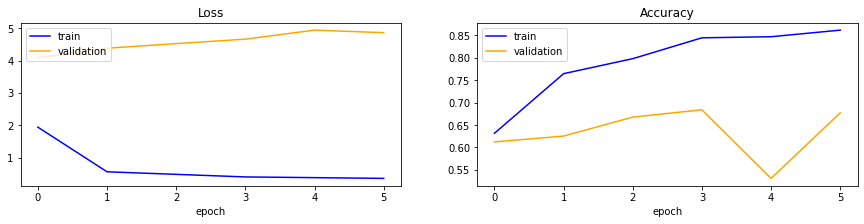

<Figure size 1080x216 with 0 Axes>

In [10]:
plt.figure(figsize=(15,3))

plt_loss = plt.subplot(1,2,1)

plt_loss.plot(hist.history['loss'], 'blue', label='train')
plt_loss.plot(hist.history['val_loss'], 'orange', label='validation')
plt_loss.set_title('Loss')
plt_loss.set_xlabel('epoch')
plt_loss.legend(loc='upper left')

plt_accuracy = plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], 'blue', label='train')
plt_accuracy.plot(hist.history['val_accuracy'], 'orange', label='validation')
plt_accuracy.set_title('Accuracy')
plt_accuracy.set_xlabel('epoch')
plt_accuracy.legend(loc='upper left')
plt.figure(figsize=(15,3))

**Test**

predict: paper


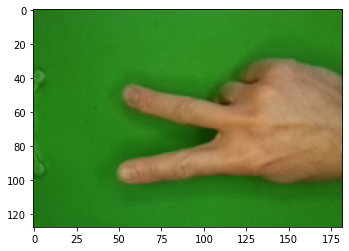

In [10]:
test_image = get_image_to_array(dir + "test_scissors.png")
plt.imshow(test_image)
# 데이터 1개 테스트
test_image = test_image.astype('float32')
test_image /= 255
test_image = test_image.reshape((1,) + input_shape)

# model.predict(test_image)
predict = np.argmax(model.predict(test_image), axis=-1)[0]
category = categories[predict.tolist()]
print("predict:", category)
